In [1]:
import numpy as np
import csv
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

Facial Point Detection is used  
Y. Sun, X. Wang, and X. Tang. Deep Convolutional Network Cascade for Facial Point Detection. In Proceedings 
   of IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2013. 
It can detect five points(two for eyes, one for nose, two for mouth) on the face.

We can grap the eye area, or nose/mouth area, and train CNN model with the grapped area. And compare the metric with CNN model trained using whole face images.

### Preprocessing with the raw images

In [2]:
from shutil import copyfile
des_dir = 'code_point/image/'

def file_read_txt(minimum_face):
    # clean the files in des_dir
    for img in os.listdir(des_dir):
        os.remove(os.path.join(des_dir, img))
    folder = 'code_face/lfw_funneled/'
    text_file = open("imagelist.txt", "w")
    person_name = [ person for person in os.listdir(folder) if not person.endswith('.txt')] 
    for i in person_name:
        person_dir = os.path.join(folder, i)
        file_name = os.listdir(person_dir)
        if(len(file_name)>= minimum_face):
            for images in file_name:
                image_dir = os.path.join(person_dir, images)
                text_file.write(os.path.join(person_dir, images)[10:])
                text_file.write('\n')
                # copy the image to default directory for point detection
                des_file = os.path.join(des_dir, images)
                copyfile(image_dir, des_file)
    text_file.close()   

In [3]:
file_read_txt(25)

#### Clean the bounding box information

In [4]:
with open('code_face/bbox.txt', 'r') as file:
        reader = csv.reader(file, delimiter=' ')
        text_file = open("bbox_clean.txt", "w")
        for row in reader:
            clean_item = []
            # delete the folder name with the image
            m = re.split('\/',row[0])
            clean_item.append(m[2])
            
            # correct detected
            if (len(row)==5):
                clean_item += row[1:5]
            # use the default value if no detected
            if (len(row)==1):
                clean_item +=  ['70', '195', '78', '172']
            # extra one face detected  use the central one  
            if (len(row)==9): 
                if (abs(int(row[1])-70)< abs(int(row[5])-70)):
                    clean_item += row[1:5]
                else:
                    clean_item += row[5:9]
            # extra two faces detected         
            if (len(row)==13):
                if  (abs(int(row[1])-70)< abs(int(row[5])-70)) and (abs(int(row[1])-70)< abs(int(row[9])-70)):
                    clean_item += row[1:5]
                elif(abs(int(row[5])-70)< abs(int(row[1])-70)) and (abs(int(row[5])-70)< abs(int(row[9])-70)):
                    clean_item += row[5:9]
                elif(abs(int(row[9])-70)< abs(int(row[1])-70)) and (abs(int(row[9])-70)< abs(int(row[5])-70)):
                    clean_item += row[9:13]
            for i in clean_item:    
                    text_file.write(i + ' ')
            text_file.write('\n')       
        text_file.close()   

#### Get the face points positions

In [2]:
import numpy as np
f = open("code_point/result.bin", "rb")
n_imgs = np.fromfile(f, count=1, dtype=np.int32)
n_points = np.fromfile(f, count=1, dtype=np.int32)
valid =  np.fromfile(f, count=n_imgs[0], dtype=np.int8)
FacePoints = np.zeros([n_imgs[0], 10], dtype=np.int32)
for i in range(n_imgs):
    FacePoints[i] =  np.fromfile(f, count=10, dtype=np.float64)
f.close()    

#### Read from  the raw images

In [3]:
from skimage import data 
import numpy as np
import scipy.misc

def capture_images(file_txt, scale=True, height=62, width=47):
    
    with open(file_txt, 'r') as file:
        reader = csv.reader(file, delimiter=' ')         
        X_images = []
        Y = []
        bbox = []
        for row in reader:            
            m = re.match('^(\w+)_', row[0])
            Y.append(m.group()[:-1])
            
            filename = os.path.join('code_point/image/', row[0])
            left = int(row[1])
            right = int(row[2])
            top = int(row[3])
            bottom = int(row[4])
            bbox.append([left, right, top, bottom])
            
            if(scale):
                image_data = data.imread(filename, as_grey=True)                          
                image_data = image_data[top:bottom, left:right]
                # resize to uniform size
                image_data = scipy.misc.imresize(image_data, (height, width, 1), interp='bilinear')
                image_data = image_data.reshape(height, width, 1)
            else:
                image_data = data.imread(filename) 
            X_images.append(image_data)

    X_images = np.asarray(X_images)
    Y = np.asarray(Y)
    bbox = np.asarray(bbox)
    if(scale): 
        return X_images, Y
    else:
        return X_images, Y, bbox

In [21]:
X_images, Y, bbox = capture_images('bbox_clean.txt', scale=False)

#### Check the bouding box and face points on images

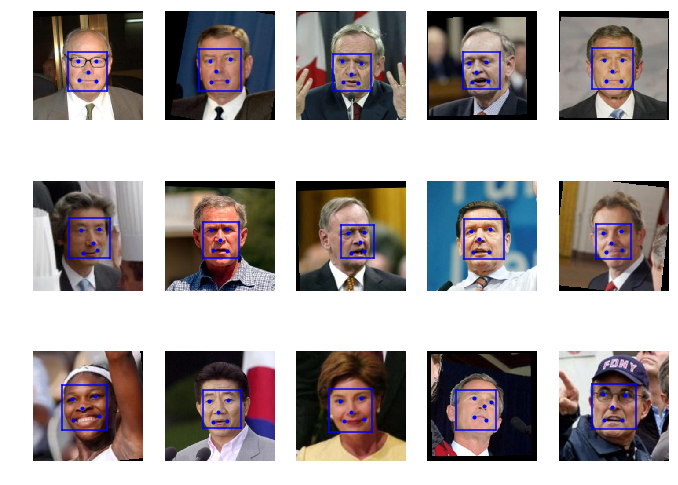

In [22]:
import random

plt.figure(figsize=(1.8 * 5, 2.4 * 3))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)

for i in range(15):    
    plt.subplot(3, 5, i+1)
    idx = random.randint(0, len(X_images)-1)
    left, right, top, bottom = bbox[idx]
    plt.imshow(X_images[idx].reshape(250, 250, 3))
    plt.plot([FacePoints[idx][0],FacePoints[idx][2],FacePoints[idx][4],FacePoints[idx][6], FacePoints[idx][8]], \
             [FacePoints[idx][1],FacePoints[idx][3],FacePoints[idx][5],FacePoints[idx][7], FacePoints[idx][9]], 'bo', markersize=3)
    plt.plot([left, right], [top, top], color='b')
    plt.plot([left, right], [bottom, bottom], color='b')
    plt.plot([left, left],  [top, bottom], color='b')
    plt.plot([right, right], [top, bottom], color='b')
    plt.axis('off')

#### Load the data

In [4]:
X_images, Y  = capture_images('bbox_clean.txt', scale=True)

##### Represent names by numbers

In [5]:
data_dic = {}
for id, name in enumerate(np.unique(Y)):
    data_dic[name] = id

In [6]:
Y_label = []
for i in Y:
    Y_label.append(data_dic[i])
Y_label = np.asarray(Y_label)   

#### Grap the eyes area

In [7]:
def capture_eyes(file_txt):
    
    with open(file_txt, 'r') as file:
        reader = csv.reader(file, delimiter=' ')         
        X_eyes = []
        
        for idx, row in enumerate(reader):                 
            filename = os.path.join('code_point/image/', row[0])            
            image_data = data.imread(filename, as_grey=True) 
            
            height = (FacePoints[idx][1]+ FacePoints[idx][3])/2
            top =  height+14
            bottom = height-18
            left = FacePoints[idx][0]-20
            right= FacePoints[idx][2]+20
            image_data = image_data[bottom:top, left:right]
            
            image_data = scipy.misc.imresize(image_data, (32, 64), interp='bilinear')
            image_data = image_data.reshape(32, 64)
            X_eyes.append(image_data)

    X_eyes = np.asarray(X_eyes) 
    return X_eyes

In [8]:
X_eyes = capture_eyes('bbox_clean.txt') 

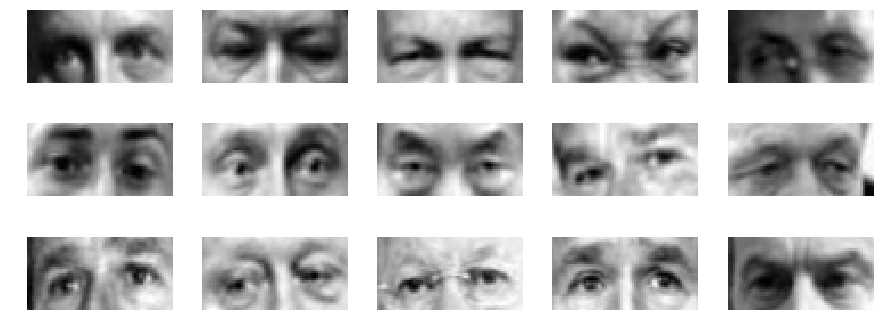

In [9]:
import random
plt.figure(figsize=(2.4 * 5, 1.6 * 3))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(15):    
    plt.subplot(3, 5, i+1)
    idx = random.randint(0, len(X_eyes)-1)
    plt.imshow(X_eyes[idx].reshape(32, 64), cmap=plt.cm.gray) 
    plt.axis('off')

#### Grap the nose area

In [9]:
def capture_nose(file_txt):
    
    with open(file_txt, 'r') as file:
        reader = csv.reader(file, delimiter=' ')         
        X_nose = []
        
        for idx, row in enumerate(reader):                 
            filename = os.path.join('code_point/image/', row[0])            
            image_data = data.imread(filename, as_grey=True) 
            
            top =  FacePoints[idx][5]+13
            bottom = FacePoints[idx][5]-15
            left = FacePoints[idx][4]-20
            right= FacePoints[idx][4]+20
            image_data = image_data[bottom:top, left:right]
            
            image_data = scipy.misc.imresize(image_data, (24, 32), interp='bilinear')
            image_data = image_data.reshape(24, 32)
            X_nose.append(image_data)

    X_nose = np.asarray(X_nose) 
    return X_nose

In [10]:
X_nose = capture_nose('bbox_clean.txt') 

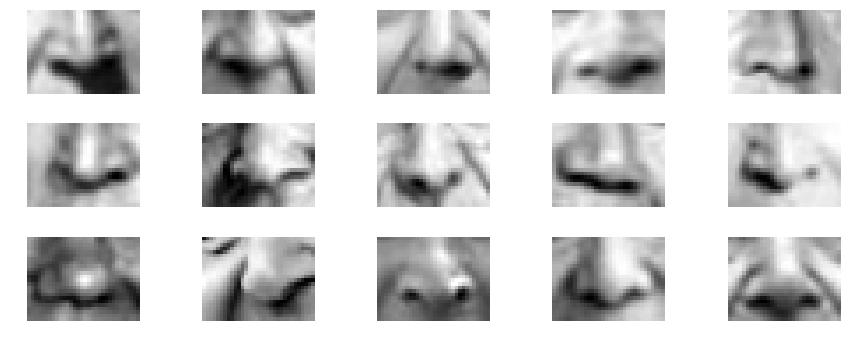

In [21]:
import random
plt.figure(figsize=(2.4 * 5, 1.6 * 3))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(15):    
    plt.subplot(3, 5, i+1)
    idx = random.randint(0, len(X_nose)-1)
    plt.imshow(X_nose[idx].reshape(24, 32), cmap=plt.cm.gray) 
    plt.axis('off')

#### Grap the mouth area

In [11]:
def capture_mouth(file_txt):
    
    with open(file_txt, 'r') as file:
        reader = csv.reader(file, delimiter=' ')         
        X_mouth = []
        
        for idx, row in enumerate(reader):                 
            filename = os.path.join('code_point/image/', row[0])            
            image_data = data.imread(filename, as_grey=True) 
            
            height = (FacePoints[idx][7]+ FacePoints[idx][9])/2
            top =  height+16
            bottom = height-10
            left = FacePoints[idx][6]-15
            right= FacePoints[idx][8]+15
            image_data = image_data[bottom:top, left:right]
            
            image_data = scipy.misc.imresize(image_data, (24, 64), interp='bilinear')
            image_data = image_data.reshape(24, 64)
            X_mouth.append(image_data)

    X_mouth = np.asarray(X_mouth) 
    return X_mouth

In [12]:
X_mouth = capture_mouth('bbox_clean.txt') 

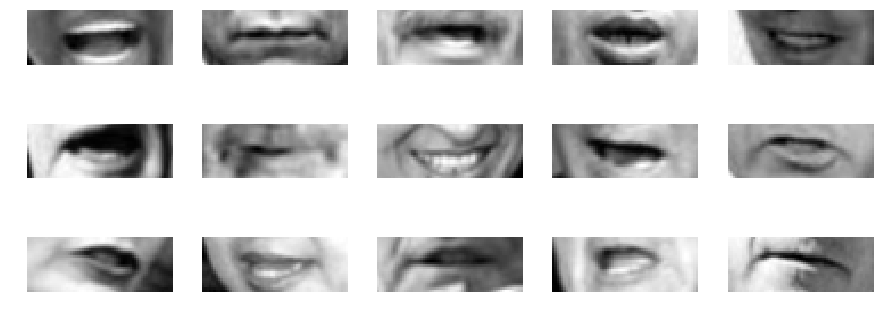

In [25]:
import random
plt.figure(figsize=(2.4 * 5, 1.6 * 3))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
for i in range(15):    
    plt.subplot(3, 5, i+1)
    idx = random.randint(0, len(X_mouth)-1)
    plt.imshow(X_mouth[idx].reshape(24, 64), cmap=plt.cm.gray) 
    plt.axis('off')

#### Reshape and split the data

In [13]:
from keras.utils import np_utils
X_set = X_images.reshape(-1, X_images.shape[1], X_images.shape[2], 1)
E_set =  X_eyes.reshape(-1, X_eyes.shape[1], X_eyes.shape[2], 1)
N_set =  X_nose.reshape(-1, X_nose.shape[1], X_nose.shape[2], 1)
M_set =  X_mouth.reshape(-1, X_mouth.shape[1], X_mouth.shape[2], 1)
Y_set = np_utils.to_categorical(Y_label, 42)

Using TensorFlow backend.


In [14]:
X_set = X_set.astype('float32')
X_set = X_set / 255.0
E_set = E_set.astype('float32')
E_set = E_set / 255.0
N_set = N_set.astype('float32')
N_set = N_set / 255.0
M_set = M_set.astype('float32')
M_set = M_set / 255.0

In [15]:
from sklearn.model_selection import train_test_split
indice = np.arange(X_set.shape[0])
X_train_, X_test, Y_train_, Y_test, idx1, idx2 = train_test_split(X_set, Y_set, indice, test_size=0.2, random_state=42)
N_train_ = N_set[idx1]
N_test   = N_set[idx2]
E_train_ = E_set[idx1]
E_test   = E_set[idx2]
M_train_ = M_set[idx1]
M_test   = M_set[idx2]

indice = np.arange(X_train_.shape[0])
X_train, X_valid, Y_train, Y_valid, idx1, idx2 = train_test_split(X_train_, Y_train_, indice, test_size=0.2, random_state=42)
N_train = N_train_[idx1]
N_valid = N_train_[idx2]
E_train = E_train_[idx1]
E_valid = E_train_[idx2]
M_train = M_train_[idx1]
M_valid = M_train_[idx2]

In [16]:
print E_train.shape, E_valid.shape, E_test.shape
print N_train.shape, N_valid.shape, N_test.shape
print M_train.shape, M_valid.shape, M_test.shape
print X_train.shape, X_valid.shape, X_test.shape
print Y_train.shape, Y_valid.shape, Y_test.shape

(1656, 32, 64, 1) (414, 32, 64, 1) (518, 32, 64, 1)
(1656, 24, 32, 1) (414, 24, 32, 1) (518, 24, 32, 1)
(1656, 24, 64, 1) (414, 24, 64, 1) (518, 24, 64, 1)
(1656, 62, 47, 1) (414, 62, 47, 1) (518, 62, 47, 1)
(1656, 42) (414, 42) (518, 42)


### Build CNN model for eye area, nose area, mouth area separately

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Input, BatchNormalization, Merge
from keras.layers import Convolution2D, MaxPooling2D, LocallyConnected2D
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.optimizers import Adam

#### 1. Eye Region

In [42]:
e_model = Sequential()
e_model.add(Convolution2D(32, 3, 3,  border_mode='same', input_shape=(32, 64, 1)))
e_model.add(Activation('relu'))
e_model.add(MaxPooling2D(pool_size=(2, 2)))
e_model.add(Dropout(0.5))

e_model.add(Convolution2D(32, 3, 3, border_mode='same'))
e_model.add(Activation('relu'))
e_model.add(MaxPooling2D(pool_size=(2, 2)))
e_model.add(Dropout(0.5))

e_model.add(Flatten())
e_model.add(Dense(512, activation='relu'))
e_model.add(Dropout(0.7))
e_model.add(Dense(42, activation='softmax'))

In [60]:
#epochs = 40
lrate = 0.0001
#decay = lrate/epochs
adam = Adam(lr= lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay= 0.0)

e_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
e_model.fit(E_train, Y_train, batch_size= 256, nb_epoch= 10, verbose=2, validation_data=(E_valid, Y_valid))

Train on 1656 samples, validate on 414 samples
Epoch 1/10
9s - loss: 0.1596 - acc: 0.9469 - val_loss: 0.7185 - val_acc: 0.8599
Epoch 2/10
8s - loss: 0.1472 - acc: 0.9493 - val_loss: 0.7159 - val_acc: 0.8527
Epoch 3/10
8s - loss: 0.1442 - acc: 0.9553 - val_loss: 0.7138 - val_acc: 0.8551
Epoch 4/10
7s - loss: 0.1646 - acc: 0.9438 - val_loss: 0.7134 - val_acc: 0.8527
Epoch 5/10
10s - loss: 0.1372 - acc: 0.9535 - val_loss: 0.7148 - val_acc: 0.8551
Epoch 6/10
9s - loss: 0.1411 - acc: 0.9571 - val_loss: 0.7166 - val_acc: 0.8551
Epoch 7/10
8s - loss: 0.1396 - acc: 0.9493 - val_loss: 0.7151 - val_acc: 0.8551
Epoch 8/10
8s - loss: 0.1604 - acc: 0.9505 - val_loss: 0.7133 - val_acc: 0.8527
Epoch 9/10
8s - loss: 0.1698 - acc: 0.9481 - val_loss: 0.7122 - val_acc: 0.8527
Epoch 10/10
8s - loss: 0.1121 - acc: 0.9638 - val_loss: 0.7107 - val_acc: 0.8527


In [90]:
e_model.save('eye_model0310.h5')

In [75]:
from keras.models import load_model
e_model = load_model('eye_model0310.h5')

In [76]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Y_pred = e_model.predict(E_test)
Y_pred_E = Y_pred

print "Precision: ", round(precision_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1),'%'  
print "Recall: ", round(recall_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1) ,'%' 

Precision:  85.4 %
Recall:  83.8 %


#### 2. Nose Region

In [76]:
n_model = Sequential()
n_model.add(Convolution2D(32, 3, 3,  border_mode='same', input_shape=(24, 32, 1)))
n_model.add(Activation('relu'))
n_model.add(MaxPooling2D(pool_size=(2, 2)))
n_model.add(Dropout(0.5))

n_model.add(Convolution2D(32, 3, 3, border_mode='same'))
n_model.add(Activation('relu'))
n_model.add(MaxPooling2D(pool_size=(2, 2)))
n_model.add(Dropout(0.5))

n_model.add(Flatten())
n_model.add(Dense(512, activation='relu'))
n_model.add(Dropout(0.7))
n_model.add(Dense(42, activation='softmax'))

In [85]:
#epochs = 40
lrate = 0.00005
#decay = lrate/epochs
adam = Adam(lr= lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay= 0.0)

n_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
n_model.fit(N_train, Y_train, batch_size= 64, nb_epoch= 10, verbose=2, validation_data=(N_valid, Y_valid))

Train on 1656 samples, validate on 414 samples
Epoch 1/10
5s - loss: 0.3056 - acc: 0.9052 - val_loss: 1.2037 - val_acc: 0.7440
Epoch 2/10
4s - loss: 0.3144 - acc: 0.8937 - val_loss: 1.2039 - val_acc: 0.7391
Epoch 3/10
4s - loss: 0.2899 - acc: 0.9034 - val_loss: 1.2032 - val_acc: 0.7391
Epoch 4/10
4s - loss: 0.3211 - acc: 0.8889 - val_loss: 1.2057 - val_acc: 0.7391
Epoch 5/10
4s - loss: 0.3021 - acc: 0.8901 - val_loss: 1.2058 - val_acc: 0.7391
Epoch 6/10
4s - loss: 0.3167 - acc: 0.8937 - val_loss: 1.2080 - val_acc: 0.7391
Epoch 7/10
4s - loss: 0.3170 - acc: 0.9028 - val_loss: 1.2073 - val_acc: 0.7440
Epoch 8/10
4s - loss: 0.2877 - acc: 0.9064 - val_loss: 1.2124 - val_acc: 0.7415
Epoch 9/10
4s - loss: 0.3084 - acc: 0.8967 - val_loss: 1.2100 - val_acc: 0.7415
Epoch 10/10
4s - loss: 0.3104 - acc: 0.9052 - val_loss: 1.2107 - val_acc: 0.7367


In [87]:
n_model.save('nose_model0310.h5')

In [77]:
from keras.models import load_model
n_model = load_model('nose_model0310.h5')

In [78]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Y_pred = n_model.predict(N_test)
Y_pred_N = Y_pred

print "Precision: ", round(precision_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1),'%'  
print "Recall: ", round(recall_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1) ,'%' 

Precision:  73.0 %
Recall:  72.6 %


#### 3. Mouth Region

In [41]:
m_model = Sequential()
m_model.add(Convolution2D(32, 3, 3,  border_mode='same', input_shape=(24, 64, 1)))
m_model.add(BatchNormalization())
m_model.add(Activation('relu'))
m_model.add(MaxPooling2D(pool_size=(2, 2)))
m_model.add(Dropout(0.5))

m_model.add(Convolution2D(32, 3, 3, border_mode='same'))
m_model.add(BatchNormalization())
m_model.add(Activation('relu'))
m_model.add(MaxPooling2D(pool_size=(2, 2)))
m_model.add(Dropout(0.5))

m_model.add(Flatten())
m_model.add(Dense(512, activation='relu'))
m_model.add(Dropout(0.7))
m_model.add(Dense(42, activation='softmax'))

In [39]:
#epochs = 40
lrate = 0.00001
#decay = lrate/epochs
adam = Adam(lr= lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay= 0.0)

m_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
m_model.fit(M_train, Y_train, batch_size= 64, nb_epoch= 10, verbose=2, validation_data=(M_valid, Y_valid))

Train on 1656 samples, validate on 414 samples
Epoch 1/10
20s - loss: 0.5260 - acc: 0.8339 - val_loss: 1.1695 - val_acc: 0.7415
Epoch 2/10
19s - loss: 0.4688 - acc: 0.8454 - val_loss: 1.1698 - val_acc: 0.7415
Epoch 3/10
18s - loss: 0.4758 - acc: 0.8400 - val_loss: 1.1714 - val_acc: 0.7440
Epoch 4/10
14s - loss: 0.4968 - acc: 0.8406 - val_loss: 1.1725 - val_acc: 0.7440
Epoch 5/10
14s - loss: 0.4935 - acc: 0.8472 - val_loss: 1.1702 - val_acc: 0.7440
Epoch 6/10
14s - loss: 0.4676 - acc: 0.8521 - val_loss: 1.1686 - val_acc: 0.7415
Epoch 7/10
14s - loss: 0.4891 - acc: 0.8418 - val_loss: 1.1649 - val_acc: 0.7415
Epoch 8/10
14s - loss: 0.4869 - acc: 0.8442 - val_loss: 1.1653 - val_acc: 0.7415
Epoch 9/10
18s - loss: 0.4788 - acc: 0.8478 - val_loss: 1.1678 - val_acc: 0.7488
Epoch 10/10
17s - loss: 0.4309 - acc: 0.8563 - val_loss: 1.1694 - val_acc: 0.7464


In [40]:
m_model.save('mouth_model0310.h5')

In [79]:
from keras.models import load_model
m_model = load_model('mouth_model0310.h5')

In [80]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Y_pred = m_model.predict(M_test)
Y_pred_M = Y_pred

print "Precision: ", round(precision_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1),'%'  
print "Recall: ", round(recall_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1) ,'%' 

Precision:  73.6 %
Recall:  72.0 %


### Merge Eye, Nose, Mouth model

In [48]:
e_model = Sequential()
e_model.add(Convolution2D(32, 3, 3,  border_mode='same', input_shape=(32, 64, 1)))
e_model.add(Activation('relu'))
e_model.add(MaxPooling2D(pool_size=(2, 2)))
e_model.add(Dropout(0.5))

e_model.add(Convolution2D(32, 3, 3, border_mode='same'))
e_model.add(Activation('relu'))
e_model.add(MaxPooling2D(pool_size=(2, 2)))
e_model.add(Dropout(0.5))

e_model.add(Flatten())
e_model.add(Dense(512, activation='relu'))
e_model.add(Dropout(0.7))

n_model = Sequential()
n_model.add(Convolution2D(32, 3, 3,  border_mode='same', input_shape=(24, 32, 1)))
n_model.add(Activation('relu'))
n_model.add(MaxPooling2D(pool_size=(2, 2)))
n_model.add(Dropout(0.5))

n_model.add(Convolution2D(32, 3, 3, border_mode='same'))
n_model.add(Activation('relu'))
n_model.add(MaxPooling2D(pool_size=(2, 2)))
n_model.add(Dropout(0.5))

n_model.add(Flatten())
n_model.add(Dense(512, activation='relu'))
n_model.add(Dropout(0.7))

m_model = Sequential()
m_model.add(Convolution2D(32, 3, 3,  border_mode='same', input_shape=(24, 64, 1)))
m_model.add(BatchNormalization())
m_model.add(Activation('relu'))
m_model.add(MaxPooling2D(pool_size=(2, 2)))
m_model.add(Dropout(0.5))

m_model.add(Convolution2D(32, 3, 3, border_mode='same'))
m_model.add(BatchNormalization())
m_model.add(Activation('relu'))
m_model.add(MaxPooling2D(pool_size=(2, 2)))
m_model.add(Dropout(0.5))

m_model.add(Flatten())
m_model.add(Dense(512, activation='relu'))
m_model.add(Dropout(0.7))

model = Sequential()
model.add(Merge([e_model, n_model, m_model], mode='concat', concat_axis=-1))
model.add(Dense(42, activation='softmax'))

In [57]:
#epochs = 40
lrate = 0.0001
#decay = lrate/epochs
adam = Adam(lr= lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay= 0.0)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.fit([E_train, N_train, M_train], Y_train, batch_size= 64, nb_epoch= 10, verbose=2, validation_data=([E_valid, N_valid, M_valid], Y_valid))

Train on 1656 samples, validate on 414 samples
Epoch 1/10
25s - loss: 0.0958 - acc: 0.9734 - val_loss: 0.6412 - val_acc: 0.8816
Epoch 2/10
24s - loss: 0.0654 - acc: 0.9764 - val_loss: 0.6476 - val_acc: 0.8792
Epoch 3/10
24s - loss: 0.0667 - acc: 0.9801 - val_loss: 0.6434 - val_acc: 0.8792
Epoch 4/10
24s - loss: 0.0767 - acc: 0.9801 - val_loss: 0.6461 - val_acc: 0.8792
Epoch 5/10
24s - loss: 0.0855 - acc: 0.9722 - val_loss: 0.6464 - val_acc: 0.8744
Epoch 6/10
24s - loss: 0.0884 - acc: 0.9771 - val_loss: 0.6461 - val_acc: 0.8744
Epoch 7/10
25s - loss: 0.0628 - acc: 0.9771 - val_loss: 0.6575 - val_acc: 0.8792
Epoch 8/10
24s - loss: 0.0869 - acc: 0.9716 - val_loss: 0.6432 - val_acc: 0.8841
Epoch 9/10
24s - loss: 0.0495 - acc: 0.9831 - val_loss: 0.6457 - val_acc: 0.8841
Epoch 10/10
24s - loss: 0.0788 - acc: 0.9777 - val_loss: 0.6537 - val_acc: 0.8792


In [58]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Y_pred = model.predict([E_test, N_test, M_test])

print "Precision: ", round(precision_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1),'%'  
print "Recall: ", round(recall_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1) ,'%' 

Precision:  88.9 %
Recall:  87.3 %


In [54]:
model.save('allmodel0312.h5')

### Merge Eye, Nose, Mouth and Entire Face model

In [63]:
e_model = Sequential()
e_model.add(Convolution2D(32, 3, 3,  border_mode='same', input_shape=(32, 64, 1)))
e_model.add(Activation('relu'))
e_model.add(MaxPooling2D(pool_size=(2, 2)))
e_model.add(Dropout(0.5))

e_model.add(Convolution2D(32, 3, 3, border_mode='same'))
e_model.add(Activation('relu'))
e_model.add(MaxPooling2D(pool_size=(2, 2)))
e_model.add(Dropout(0.5))

e_model.add(Flatten())
e_model.add(Dense(512, activation='relu'))
e_model.add(Dropout(0.7))

n_model = Sequential()
n_model.add(Convolution2D(32, 3, 3,  border_mode='same', input_shape=(24, 32, 1)))
n_model.add(Activation('relu'))
n_model.add(MaxPooling2D(pool_size=(2, 2)))
n_model.add(Dropout(0.5))

n_model.add(Convolution2D(32, 3, 3, border_mode='same'))
n_model.add(Activation('relu'))
n_model.add(MaxPooling2D(pool_size=(2, 2)))
n_model.add(Dropout(0.5))

n_model.add(Flatten())
n_model.add(Dense(512, activation='relu'))
n_model.add(Dropout(0.7))

m_model = Sequential()
m_model.add(Convolution2D(32, 3, 3,  border_mode='same', input_shape=(24, 64, 1)))
m_model.add(BatchNormalization())
m_model.add(Activation('relu'))
m_model.add(MaxPooling2D(pool_size=(2, 2)))
m_model.add(Dropout(0.5))

m_model.add(Convolution2D(32, 3, 3, border_mode='same'))
m_model.add(BatchNormalization())
m_model.add(Activation('relu'))
m_model.add(MaxPooling2D(pool_size=(2, 2)))
m_model.add(Dropout(0.5))

m_model.add(Flatten())
m_model.add(Dense(512, activation='relu'))
m_model.add(Dropout(0.7))

x_model = Sequential()
x_model.add(Convolution2D(32, 3, 3,  border_mode='same', input_shape=(62, 47, 1)))
x_model.add(Activation('relu'))
x_model.add(MaxPooling2D(pool_size=(2,2)))
x_model.add(Dropout(0.5))

x_model.add(Convolution2D(32, 3, 3, border_mode='same'))
x_model.add(Activation('relu'))
x_model.add(MaxPooling2D(pool_size=(2,2)))
x_model.add(Dropout(0.5))
        
x_model.add(Convolution2D(32, 3, 3, border_mode='same'))
x_model.add(Activation('relu'))
x_model.add(MaxPooling2D(pool_size=(2,2)))
x_model.add(Dropout(0.5))
    
x_model.add(Flatten())
x_model.add(Dense(1024, activation='relu'))
x_model.add(Dropout(0.7))

model = Sequential()
model.add(Merge([e_model, n_model, m_model, x_model], mode='concat', concat_axis=-1))
model.add(Dense(42, activation='softmax'))

In [68]:
#epochs = 40
lrate = 0.00005
#decay = lrate/epochs
adam = Adam(lr= lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay= 0.0)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
#model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.fit([E_train, N_train, M_train, X_train], Y_train, batch_size= 64, nb_epoch= 10, verbose=2, validation_data=([E_valid, N_valid, M_valid, X_valid], Y_valid))

Train on 1656 samples, validate on 414 samples
Epoch 1/10
45s - loss: 0.1882 - acc: 0.9426 - val_loss: 0.7173 - val_acc: 0.8430
Epoch 2/10
39s - loss: 0.1775 - acc: 0.9420 - val_loss: 0.7211 - val_acc: 0.8454
Epoch 3/10
38s - loss: 0.1938 - acc: 0.9366 - val_loss: 0.7293 - val_acc: 0.8406
Epoch 4/10
44s - loss: 0.2110 - acc: 0.9330 - val_loss: 0.7265 - val_acc: 0.8454
Epoch 5/10
41s - loss: 0.1826 - acc: 0.9420 - val_loss: 0.7216 - val_acc: 0.8527
Epoch 6/10
38s - loss: 0.1848 - acc: 0.9390 - val_loss: 0.7217 - val_acc: 0.8527
Epoch 7/10
39s - loss: 0.2050 - acc: 0.9312 - val_loss: 0.7188 - val_acc: 0.8502
Epoch 8/10
40s - loss: 0.1904 - acc: 0.9396 - val_loss: 0.7181 - val_acc: 0.8478
Epoch 9/10
40s - loss: 0.1615 - acc: 0.9408 - val_loss: 0.7206 - val_acc: 0.8502
Epoch 10/10
47s - loss: 0.1913 - acc: 0.9372 - val_loss: 0.7227 - val_acc: 0.8478


In [69]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

Y_pred = model.predict([E_test, N_test, M_test, X_test])

print "Precision: ", round(precision_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1),'%'  
print "Recall: ", round(recall_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1) ,'%' 

Precision:  85.4 %
Recall:  83.4 %


### Use the product of the prob.

#### The product of predicated prob. from model trained by eye, mouth, nose region

In [109]:
Y_pred = Y_pred_E * Y_pred_M * Y_pred_N

In [110]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print "Precision: ", round(precision_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1),'%'  
print "Recall: ", round(recall_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1) ,'%' 

Precision:  91.3 %
Recall:  89.8 %


#### The product of predicated prob. from model trained by eye, mouth, nose region and entire face 

In [120]:
from keras.models import load_model
x_model = load_model('x_model0310.h5')

In [122]:
Y_pred_X = x_model.predict(X_test)

In [123]:
Y_pred = Y_pred_E * Y_pred_M * Y_pred_N * Y_pred_X

In [129]:
print "Precision: ", round(precision_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1),'%'  
print "Recall: ", round(recall_score(Y_test.argmax(1), Y_pred.argmax(1), average='weighted')*100, 1) ,'%' 

Precision:  91.7 %
Recall:  90.2 %
